In [2]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# Настройка отображения
plt.style.use('default')
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

# Настройка pandas для лучшего отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("dataset_telemetry.csv")
# Преобразуем timestamp в datetime, если еще не сделано
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Извлекаем месяц и год
df['month'] = df['timestamp'].dt.to_period('M')  # или dt.strftime('%Y-%m')
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

df.head(5)

,Unnamed: 0,userid,sessionid,timestamp,action,value,category,age,gender,city,month,year_month
0,0,user_10000,1,2021-12-30 12:28:45,category,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
1,1,user_10000,1,2021-12-30 12:29:10,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
2,2,user_10000,1,2021-12-30 12:29:25,product,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
3,3,user_10000,1,2021-12-30 12:29:26,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
4,4,user_10000,1,2021-12-30 12:29:34,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12


In [3]:
# Группировка 1: Общая выручка за каждый месяц
monthly_revenue = df.groupby('year_month')['value'].sum().reset_index()
monthly_revenue.columns = ['year_month', 'total_revenue']

# Группировка 2: Уникальные активные пользователи за каждый месяц
# (пользователи, совершившие хотя бы одно действие с value > 0)
monthly_active_users = df[df['value'] > 0].groupby('year_month')['userid'].nunique().reset_index()
monthly_active_users.columns = ['year_month', 'active_users']

# Объединяем и считаем ARPU
monthly_arpu = pd.merge(monthly_revenue, monthly_active_users, on='year_month', how='left')
monthly_arpu['ARPU'] = monthly_arpu['total_revenue'] / monthly_arpu['active_users']

print("ARPU по месяцам:")
print(monthly_arpu[['year_month', 'ARPU', 'total_revenue', 'active_users']])

ARPU по месяцам:
   year_month           ARPU  total_revenue  active_users
0     2021-12   51811.649546   7.424609e+07          1433
1     2022-01  207098.675470   5.169183e+08          2496
2     2022-02  147972.083577   3.690424e+08          2494
3     2022-03  165592.925706   4.129888e+08          2494
4     2022-04  158616.830453   3.960662e+08          2497
5     2022-05  163391.129571   4.071707e+08          2492
6     2022-06  158590.414201   3.948901e+08          2490
7     2022-07  164157.635453   4.094091e+08          2494
8     2022-08  162981.199196   4.059862e+08          2491
9     2022-09  197879.893167   4.941061e+08          2497
10    2022-10  165820.412884   4.128928e+08          2490
11    2022-11  159623.003878   3.982594e+08          2495
12    2022-12  209951.289987   5.238285e+08          2495
13    2023-01  204076.020055   5.083534e+08          2491
14    2023-02  149214.470273   3.715440e+08          2490
15    2023-03  164020.432576   4.093950e+08          24

In [4]:
# Создаем копию данных для безопасности
df_analysis = df.copy()

# Преобразуем timestamp и добавляем месяц
df_analysis['timestamp'] = pd.to_datetime(df_analysis['timestamp'])
df_analysis['year'] = df_analysis['timestamp'].dt.year
df_analysis['month'] = df_analysis['timestamp'].dt.month
df_analysis['year_month'] = df_analysis['timestamp'].dt.strftime('%Y-%m')

# Вариант A: Стандартный ARPU (все пользователи с value > 0)
df_value_users = df_analysis[df_analysis['value'] > 0].copy()

# Считаем ARPU
arpu_results = []
for month in sorted(df_value_users['year_month'].unique()):
    month_data = df_value_users[df_value_users['year_month'] == month]
    
    total_revenue = month_data['value'].sum()
    unique_payers = month_data['userid'].nunique()
    
    if unique_payers > 0:
        arpu = total_revenue / unique_payers
    else:
        arpu = 0
    
    arpu_results.append({
        'year_month': month,
        'total_revenue': total_revenue,
        'unique_payers': unique_payers,
        'ARPU': arpu,
        'avg_value_per_transaction': month_data['value'].mean() if len(month_data) > 0 else 0,
        'transactions_count': len(month_data)
    })

arpu_df = pd.DataFrame(arpu_results)

print("=" * 60)
print("ARPU по месяцам:")
print("=" * 60)
print(arpu_df.to_string(index=False))
print("\nСводная статистика:")
print(f"Средний ARPU за период: {arpu_df['ARPU'].mean():.2f}")
print(f"Максимальный ARPU: {arpu_df['ARPU'].max():.2f} ({arpu_df.loc[arpu_df['ARPU'].idxmax(), 'year_month']})")
print(f"Минимальный ARPU: {arpu_df['ARPU'].min():.2f} ({arpu_df.loc[arpu_df['ARPU'].idxmin(), 'year_month']})")

# Для каждого месяца считаем всех уникальных пользователей (не только плативших)
arpu_all_users = []

for month in sorted(df_analysis['year_month'].unique()):
    month_data = df_analysis[df_analysis['year_month'] == month]
    
    # Выручка за месяц
    month_revenue = month_data['value'].sum()
    
    # Все уникальные пользователи в месяце (даже те, кто ничего не купил)
    all_users = month_data['userid'].nunique()
    
    # Платящие пользователи
    paying_users = month_data[month_data['value'] > 0]['userid'].nunique()
    
    if all_users > 0:
        arpu_all = month_revenue / all_users
        arpu_paying = month_revenue / paying_users if paying_users > 0 else 0
    else:
        arpu_all = 0
        arpu_paying = 0
    
    arpu_all_users.append({
        'year_month': month,
        'total_revenue': month_revenue,
        'all_users': all_users,
        'paying_users': paying_users,
        'ARPU_all_users': arpu_all,
        'ARPU_paying_users': arpu_paying,
        'conversion_rate': (paying_users / all_users * 100) if all_users > 0 else 0
    })

arpu_complete_df = pd.DataFrame(arpu_all_users)

print("\n" + "=" * 80)
print("Расширенный анализ ARPU:")
print("=" * 80)
print(arpu_complete_df.to_string(index=False))

ARPU по месяцам:
year_month  total_revenue  unique_payers          ARPU  avg_value_per_transaction  transactions_count
   2021-12   7.424609e+07           1433  51811.649546               18935.499566                3921
   2022-01   5.169183e+08           2496 207098.675470               18866.319719               27399
   2022-02   3.690424e+08           2494 147972.083577               14838.260482               24871
   2022-03   4.129888e+08           2494 165592.925706               14743.806244               28011
   2022-04   3.960662e+08           2497 158616.830453               14832.829962               26702
   2022-05   4.071707e+08           2492 163391.129571               14743.480280               27617
   2022-06   3.948901e+08           2490 158590.414201               14681.567883               26897
   2022-07   4.094091e+08           2494 164157.635453               14899.524813               27478
   2022-08   4.059862e+08           2491 162981.199196           

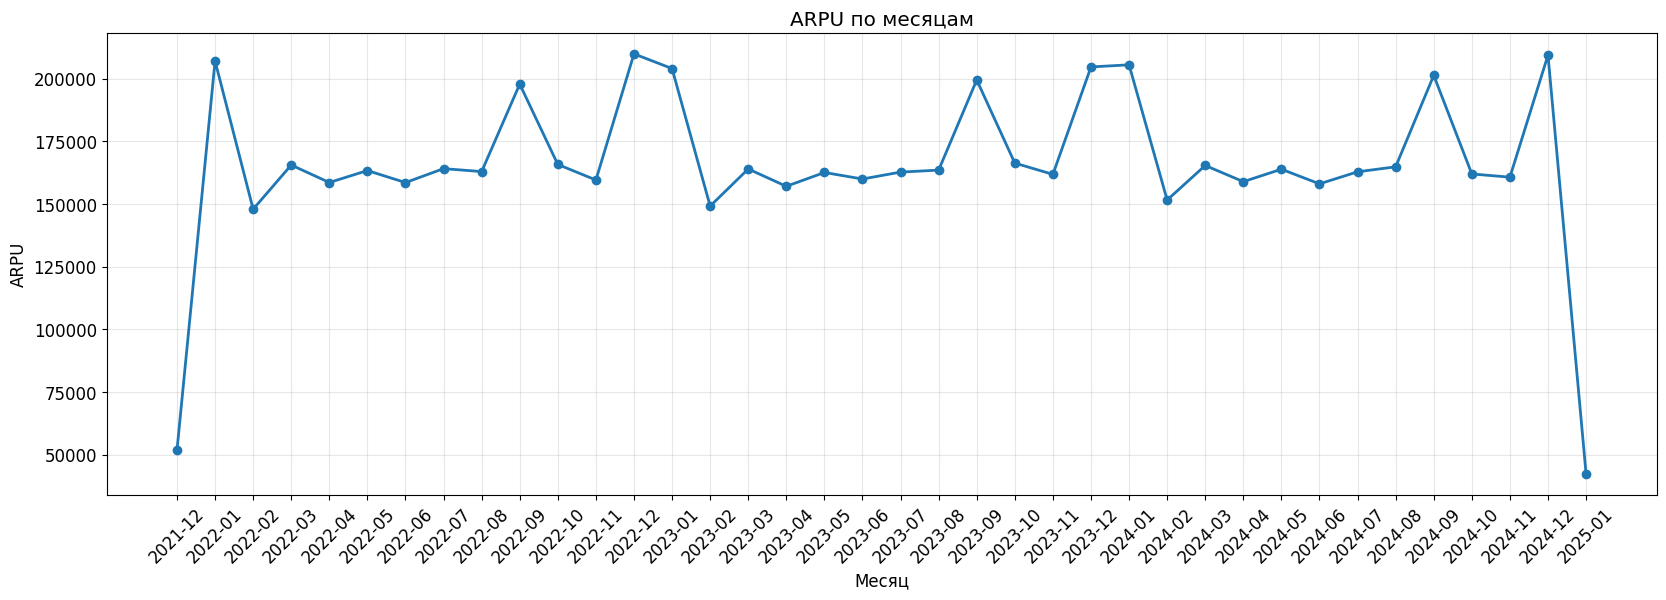

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

# График 1: ARPU по месяцам
plt.subplot(1, 1, 1)
plt.plot(arpu_df['year_month'], arpu_df['ARPU'], marker='o', linewidth=2)
plt.title('ARPU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('ARPU')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)





/var/folders/6x/h8znjt7j67z0np93fhbjn46r0000gn/T/ipykernel_700/3337798331.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(arpu_df['year_month'], rotation=45)


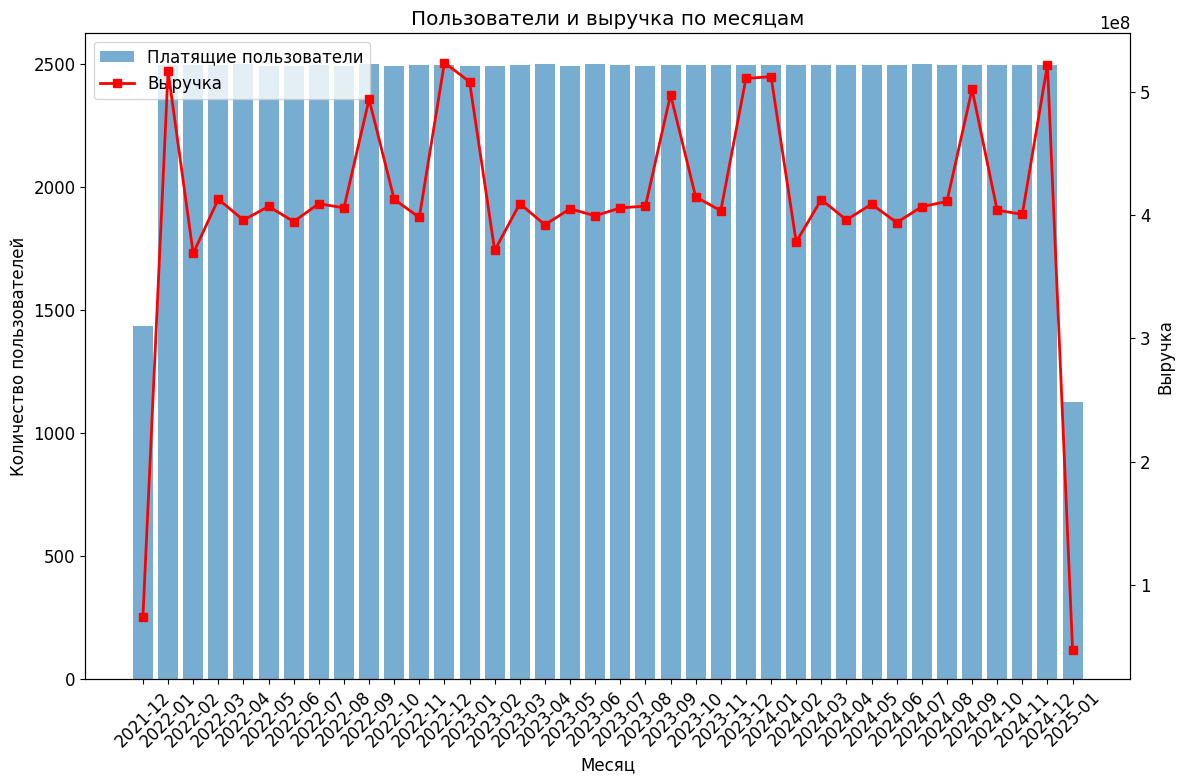

In [16]:
# График 2: Количество платящих пользователей и выручка
plt.subplot(1, 1, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.bar(arpu_df['year_month'], arpu_df['unique_payers'], alpha=0.6, label='Платящие пользователи')
ax2.plot(arpu_df['year_month'], arpu_df['total_revenue'], color='red', marker='s', 
         linewidth=2, label='Выручка')

ax1.set_xlabel('Месяц')
ax1.set_ylabel('Количество пользователей')
ax2.set_ylabel('Выручка')
ax1.set_title('Пользователи и выручка по месяцам')
ax1.set_xticklabels(arpu_df['year_month'], rotation=45)

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# ARPU по городам
city_arpu = []
for month in df_analysis['year_month'].unique():
    for city in df_analysis['city'].unique():
        month_city_data = df_analysis[(df_analysis['year_month'] == month) & 
                                      (df_analysis['city'] == city)]
        
        if len(month_city_data) > 0:
            revenue = month_city_data['value'].sum()
            users = month_city_data['userid'].nunique()
            paying_users = month_city_data[month_city_data['value'] > 0]['userid'].nunique()
            
            arpu = revenue / users if users > 0 else 0
            arpu_paying = revenue / paying_users if paying_users > 0 else 0
            
            city_arpu.append({
                'year_month': month,
                'city': city,
                'users': users,
                'paying_users': paying_users,
                'revenue': revenue,
                'ARPU': arpu,
                'ARPU_paying': arpu_paying
            })

city_arpu_df = pd.DataFrame(city_arpu)

# Топ-10 городов по ARPU за последний месяц
last_month = sorted(df_analysis['year_month'].unique())[-1]
top_cities = city_arpu_df[city_arpu_df['year_month'] == last_month].sort_values('ARPU', ascending=False).head(10)

print(f"\nТоп-10 городов по ARPU за {last_month}:")
print(top_cities[['city', 'ARPU', 'revenue', 'users']].to_string(index=False))

KeyboardInterrupt: 